# Stochastic Geomodelling in Python using GemPy

### Import

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append("../../../")
import gempy as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from gempy.utils import stochastic_surface as ss
from gempy.bayesian.posterior_analysis_DEP import calculate_probability_lithology, calculate_information_entropy
from gempy.assets import topology as tp
from tqdm import tqdm_notebook
import seaborn as sns
import pyvista as pv
from importlib import reload
reload(pv)

<module 'pyvista' from 'C:\\Users\\Alex\\Miniconda3\\envs\\topology\\lib\\site-packages\\pyvista\\__init__.py'>

### Create the Geomodel

In [3]:
geo_model = gp.create_model('Demo')
extent = [0,2000.,0,2000.,0,2000.]
gp.init_data(
    geo_model, 
    extent,[50,50,50], 
    path_o = "simple_fault_model_orientations.csv",
    path_i = "simple_fault_model_points.csv", default_values=True
)

gp.map_series_to_surfaces(
    geo_model,
    {"Fault_Series":'Main_Fault', 
     "Strat_Series": ('Sandstone_2','Siltstone', 'Shale', 'Sandstone_1', 'basement')},
    remove_unused_series=True
)
geo_model.set_is_fault(['Fault_Series']);

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.


## Visualizing the input data

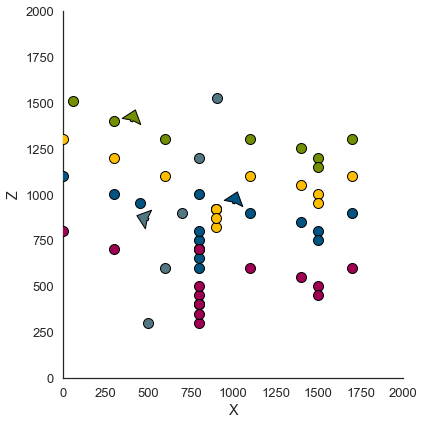

In [26]:
gp.plot.plot_data(geo_model)

In [42]:
gp._plot.plot_data_3d(geo_model, notebook=False)

In [5]:
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_compile',
)

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!


### Compute the Geomodel

In [28]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting a section through the geomodel

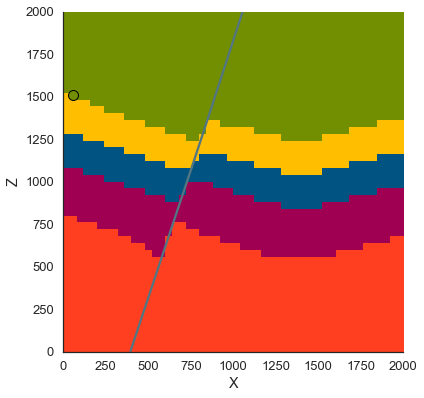

In [29]:
gp.plot.plot_section(geo_model, 24)

In [48]:
geo_model.solutions.lith_block.reshape(geo_model.grid.regular_grid.resolution)

array([[[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        ...,
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        ...,
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        ...,
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.]],

       ...,

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        ...,
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2.

### Plotting the 3-D Geomodel 

In [43]:
gp._plot.plot_3d(geo_model, render_data=False, notebook=False)

### Modeling horizon and fault uncertainties

#### Uncertainty parametrization

In [32]:
from scipy.stats import norm
smod = ss.StochasticModel(geo_model)
surface_names = np.unique(geo_model.surface_points.df.surface)

for surface in surface_names:
    if "Fault" in surface:
        dist = norm(loc=0, scale=80)
        smod.prior_surface_single(surface, dist, column="X")
    else:
        dist = norm(loc=0, scale=50)
        smod.prior_surface_single(surface, dist)

#### Uncertainty simulation

In [33]:
sols = []
graphs = []

for i in tqdm_notebook(range(10)):
    surfpts_samples, orients_samples = smod.sample()
    smod.modify(surfpts_samples, orients_samples)
    
    gp.compute_model(geo_model, compute_mesh=True)
    sols.append(geo_model.solutions.block_matrix)
    
sols = np.array(sols)

### Visualizing Uncertainty

In [34]:
sols = np.load("sols2.npy")

In [35]:
# grab the right data
lbs = sols[:, 1, 0, :].astype(int)
fbs = sols[:, 0, 0, :].astype(int)

# lithology probabilities
lb_probs = calculate_probability_lithology(lbs)
fb_probs = calculate_probability_lithology(fbs)
# information entropy
lb_ie = calculate_information_entropy(lb_probs)
fb_ie = calculate_information_entropy(fb_probs)

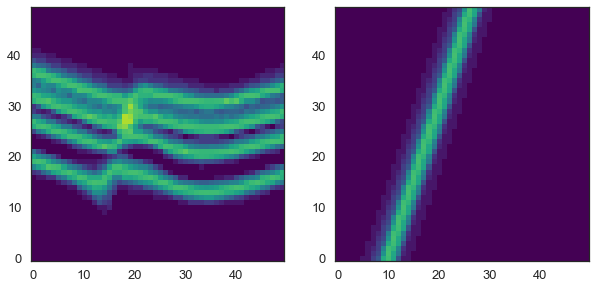

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(10,8))

ies = [lb_ie, fb_ie]

vmin, vmax = np.min(ies), np.max(ies)
imkwargs = dict(origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)

for ie, ax in zip(ies, axs):
    im = ax.imshow(ie.reshape(50, 50, 50)[:, 24, :].T, **imkwargs)

In [50]:
gpv = gp._plot.Vista(geo_model, notebook=False)

regular_grid = geo_model.grid.regular_grid
grid_values = regular_grid.values
grid_3d = grid_values.reshape(*regular_grid.resolution, 3).T

mesh = pv.StructuredGrid(*grid_3d)
mesh.point_arrays["ie"] = lb_ie + fb_ie
mesh.point_arrays["fb"] = fb_ie

# gpv.p.add_mesh(mesh)

# gpv.plot_surface("Main_Fault")

gpv.p.add_mesh_slice(mesh)

# gpv.p.add_mesh_slice_orthogonal(mesh)

gpv.p.show();

### Estimating reservoir volume uncertainty

In [40]:
def calc_vol(sols, n):
    """Calculate the volumes for a specified layer
    across all geomodels."""
    vols = []
    for sol in sols:
        lb = sol[1].astype(int)
        vol = np.count_nonzero(lb==n)
        vols.append(vol)
    return vols

Text(0.5, 1.0, 'Reservoir Volume Uncertainty')

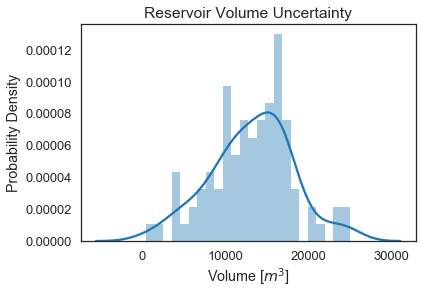

In [41]:
lb = sols[0][0].astype(int)
volumes = calc_vol(sols, 3)
ax = sns.distplot(volumes, bins=24)
ax.set_xlabel("Volume [$m^3$]")
ax.set_ylabel("Probability Density")
ax.set_title("Reservoir Volume Uncertainty")